In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from textblob import TextBlob

import warnings
warnings.filterwarnings('ignore')

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Siswantoro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Siswantoro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Preprocessing

In [2]:
df = pd.read_csv(r'./data/youtube_comments.csv')

In [3]:
df.head(2)

,Author,Comment,Published
0,@ulfianaini,"Zonasi gak berlaku di sekolah negeri favorit, ...",2024-12-16T04:12:04Z
1,@somecomfort,"test mtk, 7x8 berapa? jangan kelamaan mikirnya...",2024-12-15T08:06:03Z


In [4]:
print('total baris', df.shape[0])
print('total kolom', df.shape[1])

total baris 10099
total kolom 3


In [5]:
# Cek missing value

df.isna().sum()

Author       3
Comment      0
Published    0
dtype: int64

In [6]:
# Cek duplikasi

df.duplicated().sum()

3

In [59]:
df_clean = df.copy()

In [60]:
# Menghandle Missing Value

df_clean = df_clean.dropna()
df_clean.isna().sum()

Author       0
Comment      0
Published    0
dtype: int64

In [61]:
# Menghandle Duplikasi

df_clean = df_clean.drop_duplicates()
df_clean.duplicated().sum()

0

In [62]:
# Fungsi untuk membersihkan data

def remove_emoji(text):
    if isinstance(text, str):
        return emoji.replace_emoji(text, replace='')
    else:
        return text

def clean_text(text):
    text = remove_emoji(text)
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'@\w+|#\w+|http\S+', '', text)
        text = re.sub(r'[^a-z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_stopwords(text, stop_words):
    if isinstance(text, str):
        return ' '.join([word for word in word_tokenize(text) if word not in stop_words])
    return text

def apply_stemming(text):
    if isinstance(text, str):

        factory = StemmerFactory()
        stemmer = factory.create_stemmer()

        return stemmer.stem(text)
    return text

def tokenization(text):
    return word_tokenize(text)

In [63]:
df_clean['clean_comment'] = df_clean['Comment'].apply(clean_text)
df_clean.head(2)

,Author,Comment,Published,clean_comment
0,@ulfianaini,"Zonasi gak berlaku di sekolah negeri favorit, ...",2024-12-16T04:12:04Z,zonasi gak berlaku di sekolah negeri favorit r...
1,@somecomfort,"test mtk, 7x8 berapa? jangan kelamaan mikirnya...",2024-12-15T08:06:03Z,test mtk x berapa jangan kelamaan mikirnya tap...


In [64]:
stop_words = set(stopwords.words('indonesian'))

df_clean['clean_comment'] = df_clean['clean_comment'].apply(lambda x: remove_stopwords(x, stop_words))
df_clean.head(2)

,Author,Comment,Published,clean_comment
0,@ulfianaini,"Zonasi gak berlaku di sekolah negeri favorit, ...",2024-12-16T04:12:04Z,zonasi gak berlaku sekolah negeri favorit rela...
1,@somecomfort,"test mtk, 7x8 berapa? jangan kelamaan mikirnya...",2024-12-15T08:06:03Z,test mtk x mikirnya wk


In [65]:
df_clean['tokens'] = df_clean['clean_comment'].apply(tokenization)
df_clean.head(2)

,Author,Comment,Published,clean_comment,tokens
0,@ulfianaini,"Zonasi gak berlaku di sekolah negeri favorit, ...",2024-12-16T04:12:04Z,zonasi gak berlaku sekolah negeri favorit rela...,"[zonasi, gak, berlaku, sekolah, negeri, favori..."
1,@somecomfort,"test mtk, 7x8 berapa? jangan kelamaan mikirnya...",2024-12-15T08:06:03Z,test mtk x mikirnya wk,"[test, mtk, x, mikirnya, wk]"


In [66]:
df_clean['stem_comment'] = df_clean['tokens'].apply(apply_stemming)
df_clean.head(2)

,Author,Comment,Published,clean_comment,tokens,stem_comment
0,@ulfianaini,"Zonasi gak berlaku di sekolah negeri favorit, ...",2024-12-16T04:12:04Z,zonasi gak berlaku sekolah negeri favorit rela...,"[zonasi, gak, berlaku, sekolah, negeri, favori...","[zonasi, gak, berlaku, sekolah, negeri, favori..."
1,@somecomfort,"test mtk, 7x8 berapa? jangan kelamaan mikirnya...",2024-12-15T08:06:03Z,test mtk x mikirnya wk,"[test, mtk, x, mikirnya, wk]","[test, mtk, x, mikirnya, wk]"


In [67]:
# Membuat Label

def get_sentiment(text):

    sentiment = TextBlob(text).sentiment

    if sentiment.polarity > 0.1:
        return 'positif'
    elif sentiment.polarity < -0.1:
        return 'negatif'
    else:
        return 'netral'

df_clean['label'] = df_clean['clean_comment'].apply(get_sentiment)

In [68]:
df_clean['label'].value_counts()

label
netral     9353
positif     527
negatif     213
Name: count, dtype: int64

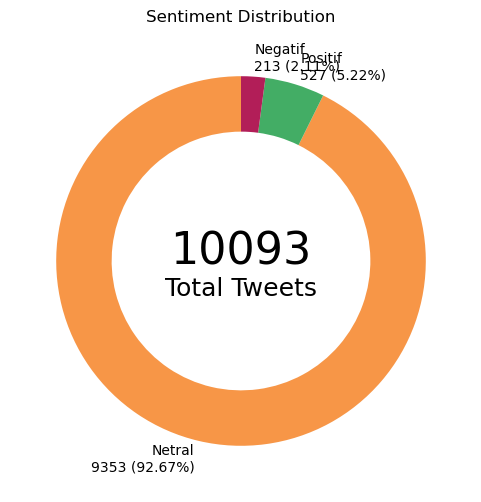

In [69]:
def plot_pie(data):

    pie_data = data.value_counts()
    color_map = {"positif": "#43AD65", "netral": "#F79647", "negatif": "#B21E58"}
    
    # Buat label
    labels = [
        (
            f"{str(pie_data.index[i]).title()}\n{pie_data.values[i]}"
            + f" ({round(pie_data.values[i] / sum(pie_data.values) * 100, 2)}%)"
        )
        for i in range(len(pie_data.values))
    ]

    # Plot pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(
        pie_data.values,
        labels=labels,
        colors=[color_map.get(str(x).lower(), "#cccccc") for x in pie_data.index],
        wedgeprops={"width": 0.3},
        startangle=90
    )

    # Informasi total
    plt.title("Sentiment Distribution", fontsize=12)
    plt.text(0, 0.05, sum(pie_data.values), ha="center", va="center", fontsize=32)
    plt.text(0, -0.15, "Total Tweets", ha="center", va="center", fontsize=18)
    plt.show()

plot_pie(df_clean["label"])

In [70]:
df_clean.sample(10)

,Author,Comment,Published,clean_comment,tokens,stem_comment,label
6959,@SekilasDunia,👍🏻👍🏻👍🏻,2024-10-12T14:45:00Z,,[],[],netral
7320,@safarwadi_afank5328,"ngeri emang Pendidikan di KONOHA ini, SDM suda...",2024-10-12T03:36:25Z,ngeri emang pendidikan konoha sdm titik rendah...,"[ngeri, emang, pendidikan, konoha, sdm, titik,...","[ngeri, emang, pendidikan, konoha, sdm, titik,...",netral
8179,@bangsast9613,"Ponakan saya kelas 3 susah baca, gatau lagi gi...",2024-10-11T06:38:27Z,ponakan kelas susah baca gatau gimana,"[ponakan, kelas, susah, baca, gatau, gimana]","[ponakan, kelas, susah, baca, gatau, gimana]",netral
2544,@sadamhusen9551,menurut saya mendikbud terdahulu sebut saja na...,2024-10-22T08:21:53Z,mendikbud namanya muhajir effendy nadiem makar...,"[mendikbud, namanya, muhajir, effendy, nadiem,...","[mendikbud, namanya, muhajir, effendy, nadiem,...",netral
4749,@kangdjosie,Saya belajar tahun 1982 - 1994.. dimana sejak ...,2024-10-16T06:40:33Z,belajar dimana sd kelas diajar guru profesiona...,"[belajar, dimana, sd, kelas, diajar, guru, pro...","[belajar, dimana, sd, kelas, diajar, guru, pro...",netral
7422,@xingxabar1919,harusnya hadirkan nara sumber yang dulu mengin...,2024-10-12T01:02:37Z,hadirkan nara sumber sistem pendidikan meniru ...,"[hadirkan, nara, sumber, sistem, pendidikan, m...","[hadirkan, nara, sumber, sistem, pendidikan, m...",netral
3061,@wongpandai,nadiem zakariem,2024-10-20T05:17:12Z,nadiem zakariem,"[nadiem, zakariem]","[nadiem, zakariem]",netral
7535,@modalhpdoang8344,Sekolah identik bully menghasilkan generasi pe...,2024-10-11T18:00:07Z,sekolah identik bully menghasilkan generasi pe...,"[sekolah, identik, bully, menghasilkan, genera...","[sekolah, identik, bully, menghasilkan, genera...",netral
8439,@Arif-jt4qg,indonesia butuh tombol reset? (revolusi ke 2),2024-10-11T04:54:12Z,indonesia butuh tombol reset revolusi,"[indonesia, butuh, tombol, reset, revolusi]","[indonesia, butuh, tombol, reset, revolusi]",netral
9240,@aristafirsantoro1776,"Kalo gw sih, kembali ke prinsip, madrasah yang...",2024-10-11T00:06:56Z,kalo gw sih prinsip madrasah utama rumah sekol...,"[kalo, gw, sih, prinsip, madrasah, utama, ruma...","[kalo, gw, sih, prinsip, madrasah, utama, ruma...",positif


### Save dataset|

In [71]:
# Simpan file

df_clean.to_csv('./data/data_clean.csv', index=False) # data yang sudah bersih            